# EDM 2021: Early Warning Prediction in MOOC-based Flipped Courses

#### Imports

In [538]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from itertools import groupby
from sklearn import metrics
from scipy.stats import gaussian_kde
from itertools import product
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import math
import sys
import os

import logging
tf.get_logger().setLevel(logging.ERROR)

import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.dummy import DummyClassifier

In [539]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

In [540]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [541]:
from extractors.lalle_conati import LalleConati
from extractors.chen_cui import ChenCui
from extractors.wan_et_al import WanEtAl
from extractors.boroujeni_et_al import BoroujeniEtAl
from extractors.lemay_doleck import LemayDoleck
from extractors.mbouzao_et_al import MbouzaoEtAl
from extractors.mubarak_et_al import MubarakEtAl
from extractors.he_et_al import HeEtAl
from extractors.akpinar_et_al import AkpinarEtAl

In [542]:
import warnings
warnings.filterwarnings('ignore')

**Helpers**

In [565]:
# Metrics helpers


# Data preparation helpers
def w4s(user_events, start_date, course_type, max_course_weeks=20):
    first_access = str(user_events['Date'].min())
    start_date = first_access if first_access > start_date and course_type is not 'flipped' else start_date 
    user_events['Week'] = order_week(user_events['Date'].apply(dt2w), start_date).astype(int)
    return user_events[user_events['Week'] < max_course_weeks]

def tmp2dt(x):
    return str2dt(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

def str2dt(ts):
    return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')

def dt2w(dt):
    return dt.strftime('%W')

def order_week(series, start_date):
    start_week = int(dt2w(str2dt(start_date)))
    nb_week = int(series.max()) + 1
    return series.apply(lambda w: str((int(w) - start_week) % nb_week)).values

def event2df(event_data):
    lst = []
    for course, data in event_data.items():  
        nstud = len(data['Clickstream']['AccountUserID'].unique())
        nvint = len(data['Clickstream'][data['Clickstream']['EventType'].str.contains('Video')])
        npint = len(data['Clickstream'][data['Clickstream']['EventType'].str.contains('Problem')])
        ctype = data['Type']
        ttype = data['Topic']
        weeks = data['Weeks']
        platf = data['Platform']
        lst.append([course, ctype, platf, ttype, weeks, nstud, nvint, npint])
    return pd.DataFrame(lst, columns=['Course', 'Type', 'Platform', 'Topic', 'Weeks', '#Students', '#VideoEvents', '#ProblemEvents'])

def merge_courses(data, lst):
    if len(lst) == 0:
        return None
    combined = data[lst[0]].copy()
    for course in lst[1:]:
        combined['Type'] = data[course]['Type']
        combined['Topic'] = data[course]['Topic']
        combined['Weeks'] = data[course]['Weeks']
        combined['Platform'] = data[course]['Platform']
        combined['Outcomes'] = combined['Outcomes'].append(data[course]['Outcomes']).reset_index(drop=True)
        combined['Clickstream'] = combined['Clickstream'].append(data[course]['Clickstream']).reset_index(drop=True)
    return combined

## **** Parameters ****

In [556]:
params = {
    'courses': [
        ('EPFL-AlgebreLineaire-2018', 'flipped', 'mathematics', 4, 20),
        ('EPFL-AlgebreLineaire-2019', 'flipped', 'mathematics', 4, 20),
        ('EPFL-CS-210-2018_t3', 'flipped', 'computer science', 0, 20),
        ('EPFL-CS-206-2019_T1', 'flipped', 'computer science', 0, 20)
    ],
    'video_events': ['Video.Pause', 'Video.Load', 'Video.Play', 'Video.Seek', 'Video.Stop', 'Video.SpeedChange'],
    'problem_events': ['Problem.Check'],
    'target': 'Flag',
    'thresholds': {'edx': 0.60, 'coursera': 0.80, 'courseware': 0.75},
    'min_course_weeks': 4,
    'max_course_weeks': 22,
    'min_events': 100,
    'n_splits': 3,
    'ftime_mode': ['week'],
    'concat_mode': ['vec', 'avg']
}

## ** Data Preparation **

### Data Ingestion

In [557]:
course_metadata = pd.read_csv(os.path.join('..', 'loaders', 'course_metadata.csv'))

In [558]:
course_metadata.head()

,StartDate,EndDate,OfficialTitle,Session,AcademicPeriod,EPFLCourse,TeachersISA,Type,DataPackageID
0,2013-09-23 00:00:00,2013-11-11 00:00:00,Initiation ? la Programmation en Java,1,Fall,CS-111(i),Jamila Sam,Fall,intro-java-fr-001
1,2014-09-05 00:00:00,2014-10-27 00:00:00,Initiation ? la Programmation en Java,2,Fall,CS-111(a),Jean-Philippe Pellet,Fall,initprogjava-001
2,2015-09-04 00:00:00,2015-10-25 00:00:00,Initiation ? la Programmation en Java,3,Fall,CS-111(a),Jean-Philippe Pellet,Fall,initprogjava-002
3,2013-09-13 00:00:00,2013-11-15 00:00:00,L'Art des Structures I - C?bles et arcs,1,Fall,CIVIL-122,Olivier Burdet,Fall,structures-001
4,2014-02-21 00:00:00,2014-05-02 00:00:00,L'Art des Structures I - C?bles et arcs,2,Spring,CIVIL-122,Olivier Burdet,Fall,structures-002


In [563]:
event_data = {}

for course, course_type, course_topic, first_week, last_week in tqdm(params['courses']):
    event_data[course] = {} 
    
    # Define paths
    labels_path = os.path.join('..', 'loaders', 'request_2021jan26_labels', 'request_2021jan26_final_grades_ca_courseware_' + course + '.csv')
    video_path = os.path.join('..', 'loaders', 'request_2021jan26_video_events', 'request_2021jan26_video_events_ca_courseware_' + course + '.csv')
    problems_path = os.path.join('..', 'loaders', 'request_2021jan26_problem_events', 'request_2021jan26_problem_events_ca_courseware_' + course + '.csv')
    
    # Load clickstream and labels
    if os.path.exists(labels_path):
        labels = pd.read_csv(labels_path)
    if os.path.exists(video_path):
        events = pd.read_csv(video_path).rename(columns={'AccountUserHash': 'AccountUserID'})
    if os.path.exists(problems_path):
        problems = pd.read_csv(problems_path).rename(columns={'AccountUserHash': 'AccountUserID'})
        problems = problems[problems['Grade'].notnull()]
        events = events.append(problems)
    
    # Compute string date and weekday
    cmetadata = course_metadata[course_metadata['DataPackageID'] == course]
    start_date = cmetadata['StartDate'].values[0]
    end_date = cmetadata['EndDate'].values[0]
    
    events['Date'] = events['TimeStamp'].apply(tmp2dt)
    events['Weekday'] = events['Date'].apply(lambda x: x.weekday())
    events = events[events['Date'] >= str2dt(start_date)]
    events = events[events['Date'] <= str2dt(end_date)] if not end_date is not 'nan' else events
    
    # Compute weeks per student and filter
    user_events_lst = []
    for user_id, user_events in events.groupby(by='AccountUserID'):
        nevents = len(user_events.index)
        nweeks = int(user_events['Date'].apply(dt2w).max())
        if nevents > params['min_events'] and nweeks > params['min_course_weeks']:
            user_events_lst.append(w4s(user_events, start_date, course_type, params['max_course_weeks']))
    events = pd.concat(user_events_lst)
    
    # Remove first weeks
    events['Week'] = events['Week'] - first_week
    events = events[events['Week'] >= 0]
    
    # Filter students based on labels and events
    active_user_ids = labels['AccountUserID'].unique()
    user_ids = set(active_user_ids) & set(events['AccountUserID'])
    events = events[events['AccountUserID'].isin(user_ids)]
    labels = labels[labels['AccountUserID'].isin(user_ids)]
    
    # Clean event types
    events = events[events['EventType'].isin(params['video_events'] + params['problem_events'])].sort_values(by='Date')
    if 'ProblemID' in events.columns:
        events = events.drop_duplicates(subset=['ProblemID', 'EventType', 'TimeStamp'], keep='first')
    events['Year'] = int(course.split('-')[-1][:4])
    
    # Store data in a dictionary for future usage
    event_data[course]['Type'] = course_type 
    event_data[course]['Topic'] = course_topic
    event_data[course]['Outcomes'] = labels.reset_index(drop=True)
    event_data[course]['Platform'] = 'courseware' 
    event_data[course]['Weeks'] = last_week - first_week
    event_data[course]['Clickstream'] = events.sort_values(by=['Date']).reset_index(drop=True)

100%|██████████| 4/4 [01:07<00:00, 16.94s/it]


In [566]:
event2df(event_data)

,Course,Type,Platform,Topic,Weeks,#Students,#VideoEvents,#ProblemEvents
0,EPFL-AlgebreLineaire-2018,flipped,courseware,mathematics,16,104,205490,23084
1,EPFL-AlgebreLineaire-2019,flipped,courseware,mathematics,16,110,225843,24792
2,EPFL-CS-210-2018_t3,flipped,courseware,computer science,20,216,402445,5125
3,EPFL-CS-206-2019_T1,flipped,courseware,computer science,20,143,132233,0


### Data Merging

Since Fall 2017, the stream of the EPFL's Linear Algebra course has been taught in a flipped format. The implementation of the flipped classroom was carried out in an incremental manner, as described below:

- **Year 2017-2018**: traditional manner (weeks 1-13) - flipped manner (week 14).
- **Year 2018-2019**: traditional manner (weeks 1-4, 10-14) - flipped manner (weeks 5-9).
- **Year 2019-2020**: traditional manner (weeks 1-4) - flipped manner (weeks 5-14).

We consider the last two years together, while we discarded the first year as only the last week was flipped. 

In [567]:
raw_event_data = event_data

In [569]:
event_data = {}
event_data['LinearAlgebra'] = merge_courses(raw_event_data, ['EPFL-AlgebreLineaire-2018', 'EPFL-AlgebreLineaire-2019'])
event_data['FunctionalProgramming'] = merge_courses(raw_event_data, ['EPFL-CS-210-2018_t3'])
event_data['ParallelismConcurrency'] = merge_courses(raw_event_data, ['EPFL-CS-206-2019_T1'])

In [570]:
event2df(event_data)

,Course,Type,Platform,Topic,Weeks,#Students,#VideoEvents,#ProblemEvents
0,LinearAlgebra,flipped,courseware,mathematics,16,214,431333,47876
1,FunctionalProgramming,flipped,courseware,computer science,20,216,402445,5125
2,ParallelismConcurrency,flipped,courseware,computer science,20,143,132233,0


### Data Labelling

- **Dropout** {0, 1}. A student drops out if they do not complete a course, operationalized as whether a student continues participating in a course until it ends. 
- **Stopout** [1, nweeks]. A student is a “stopout” if they stop engaging with the course prior to the end of the course. Often, stopout is functionally equivalent to dropout, but emphasizes that we often cannot observe a students’ intention to drop out and instead only observe whether they stop interacting. 
- **Final Course Grade** [1, maxgrade]. The students’ overall grade in the course, calculated based on the instructors’ specification. Typically, course grades are a mix of one or more of the following: quizzes, homework assignments, problem sets, human-graded assignments, and exams.  
- **Pass-Fail** {0, 1}. A student typically passes a course if they meet or exceed an instructor-specified overall grade threshold; otherwise they fail.

#### Dropout & Stopout

In [586]:
for course in event_data.keys():
    course_data = event_data[course]
    max_week = course_data['Clickstream'].groupby(by='AccountUserID')['Week'].max()
    dropouts, stopouts = [], []
    for index, row in tqdm(course_data['Outcomes'].iterrows()):
        dropouts.append(1 if max_week[row['AccountUserID']] < course_data['Weeks'] - 7 else 0) #9 is the 14 - 4 (non flipped) number of weeks
        stopouts.append(max_week[row['AccountUserID']])
    course_data['Outcomes']['Dropout'] = np.array(dropouts)
    course_data['Outcomes']['Stopout'] = np.array(stopouts)

214it [00:00, 5799.34it/s]
217it [00:00, 7252.88it/s]
148it [00:00, 7420.17it/s]


#### Pass-Fail

In [587]:
for course in event_data.keys():
    course_data = event_data[course]
    course_data['Outcomes']['Pass-Fail'] = course_data['Outcomes']['Grade'].apply(lambda x: 1 if x < 4.0 else 0)

## ** Data Exploration ** 

#### Grades and labels analysis

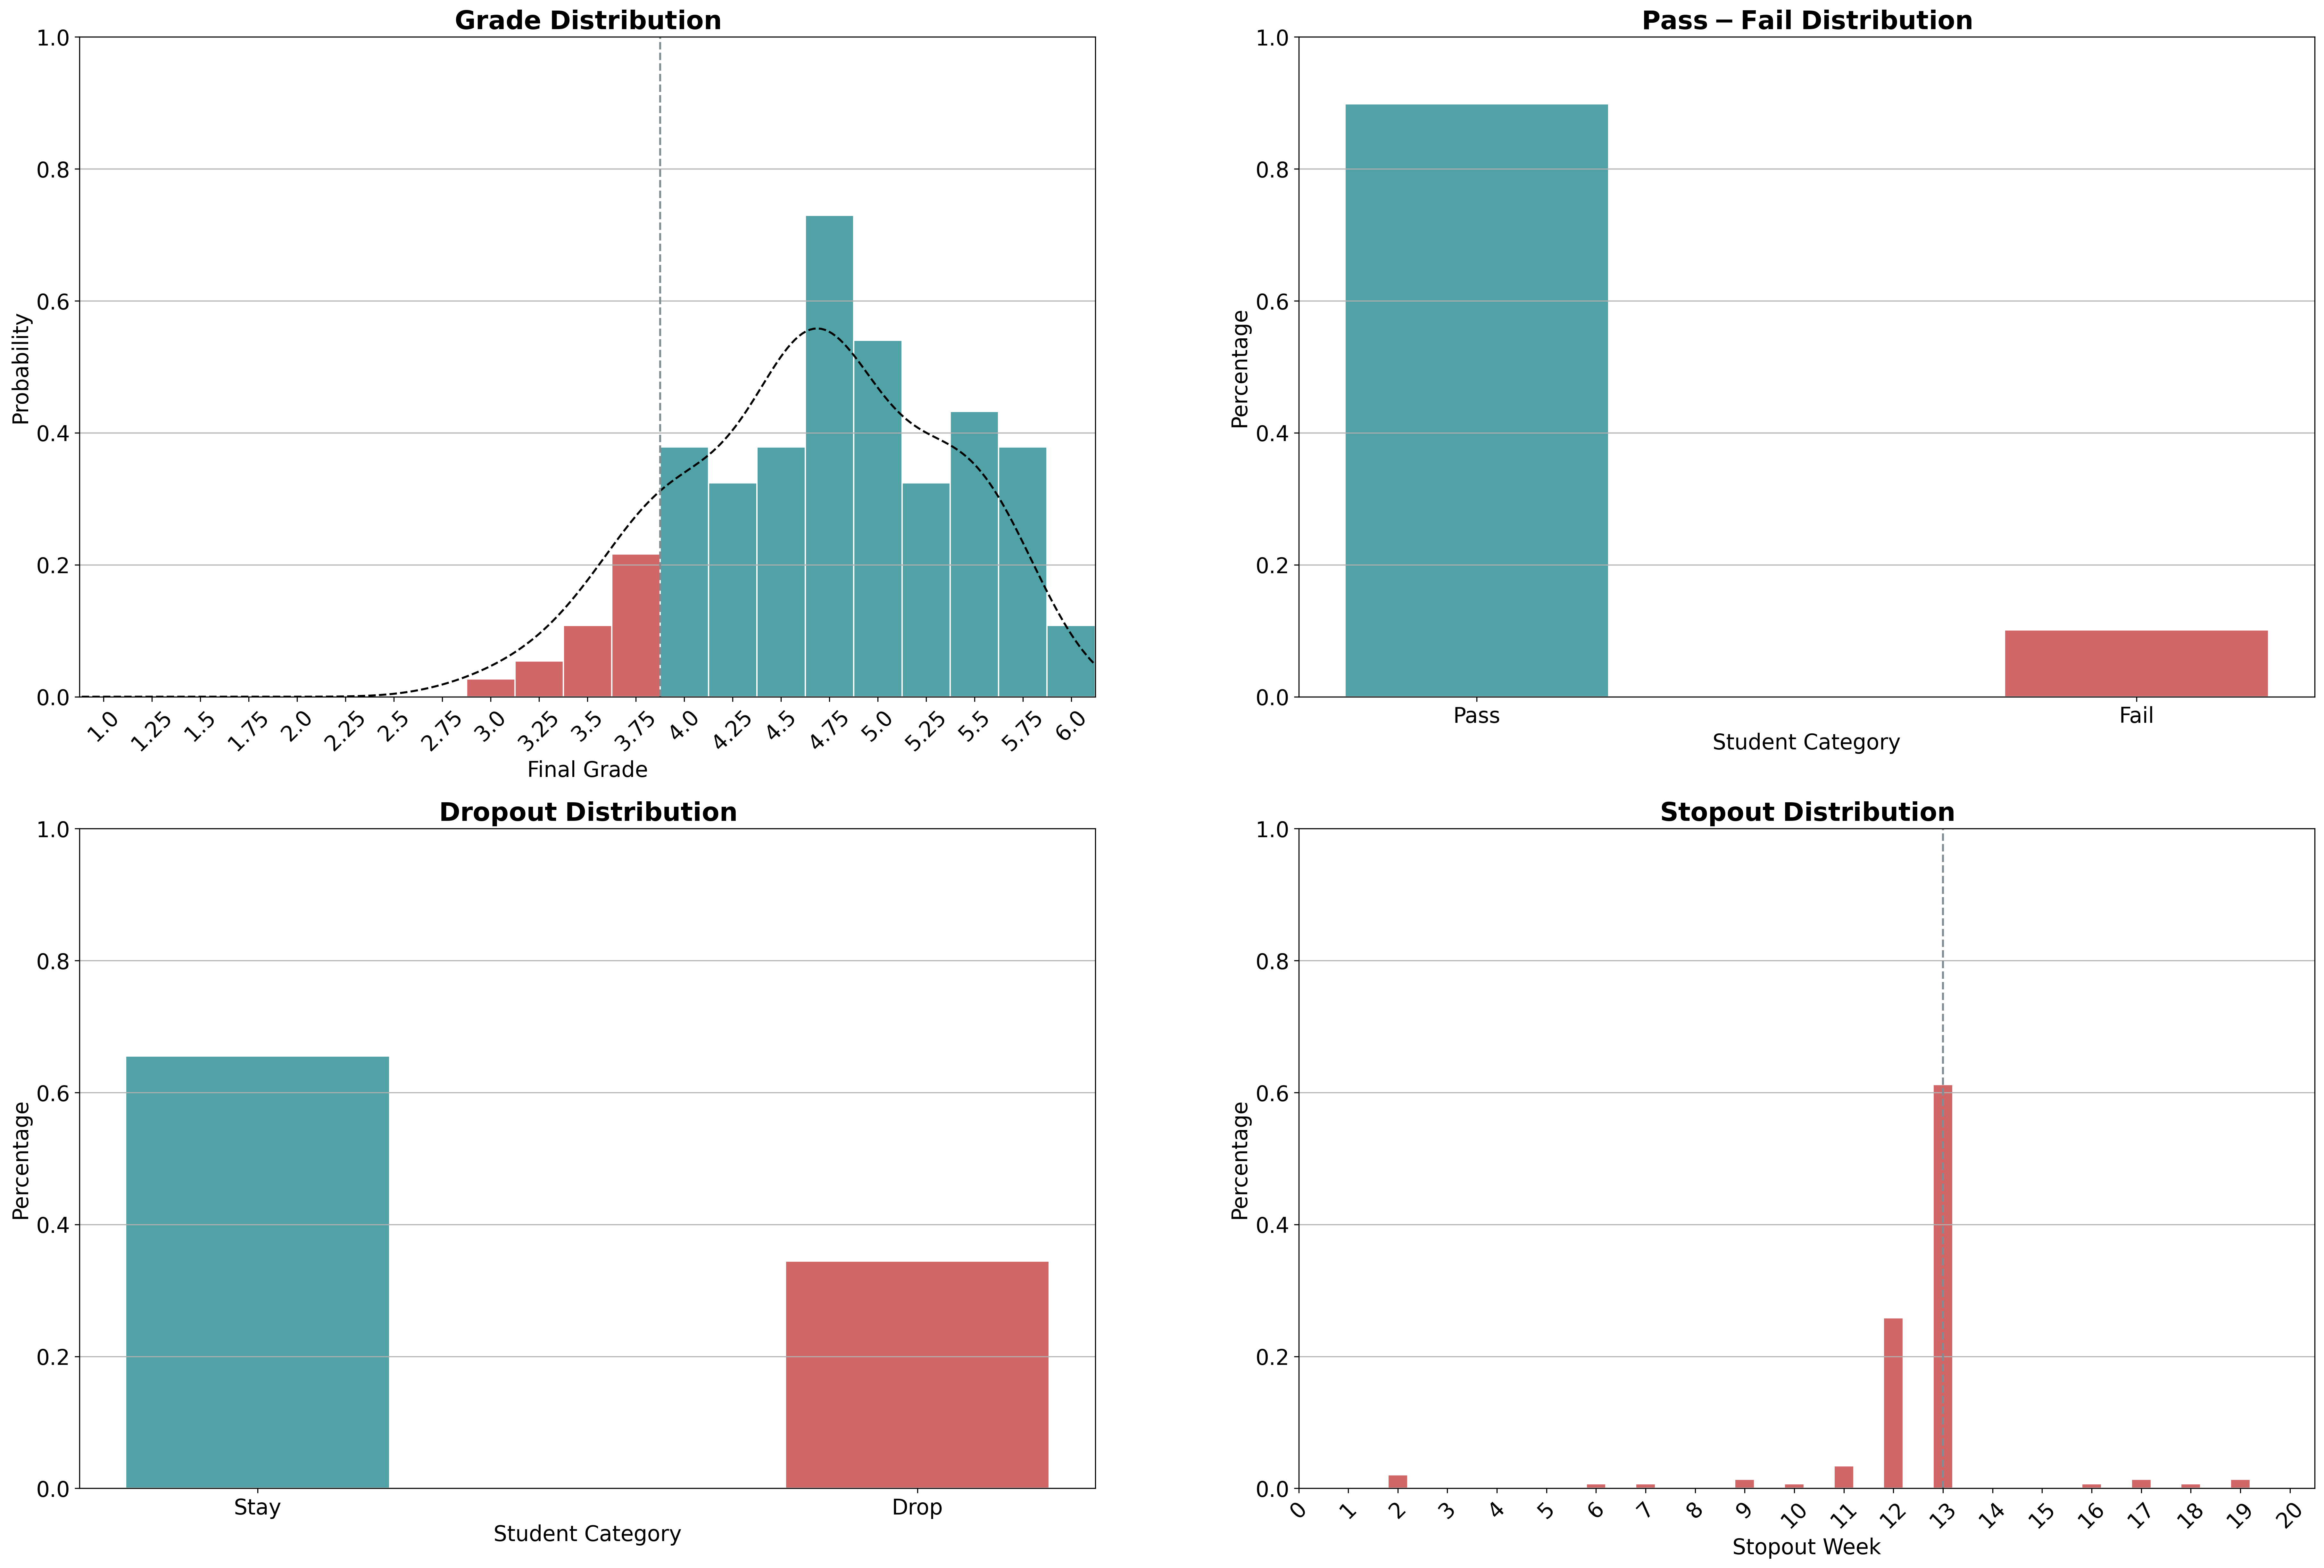

In [591]:
course_data = event_data['ParallelismConcurrency']

plt.figure(figsize=(30, 20), dpi=300)
plt.rcParams.update({'font.size': 16})

plt.subplot(2, 2, 1)

# Data
mingrade = 1
maxgrade = 6
depgrade = .25
thrgrade = 4.0
grades = np.arange(mingrade, maxgrade + 2 * depgrade, depgrade)
x = course_data['Outcomes']['Grade'].values

# Histogram 
N, bins, patches = plt.hist(x, density=True, bins=grades, edgecolor='white', label='Data')  
bin_w = (max(grades) - min(grades)) / (len(grades) - 1)
plt.xticks(np.arange(min(grades) + bin_w / 2, max(grades), bin_w), grades[:-1], rotation=45)

for i in range(0, len(grades[grades < thrgrade])):
    patches[i].set_facecolor('#D16666')
for i in range(len(grades[grades < thrgrade]), len(patches)):
    patches[i].set_facecolor('#50A2A7')

# Line distribution
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs), label='PDF', color='#000000', linestyle='--')

# Line vertical
plt.axvline(x=thrgrade, color='#818D92', linestyle='--')

# Decoration
plt.title(r'$\bf{Grade}$ $\bf{Distribution}$')
plt.ylabel('Probability')
plt.xlabel('Final Grade')
plt.xlim([mingrade, maxgrade + depgrade])
plt.ylim([0.0, 1.0])
plt.grid(axis='y')

plt.subplot(2, 2, 2)

# Data
x = course_data['Outcomes']['Pass-Fail'].to_list()

# Bar Plot 
plt.bar(['Pass', 'Fail'], [x.count(0)/len(x),x.count(1)/len(x)], color=['#50A2A7','#D16666'], width=0.4, edgecolor='white') 

# Decoration
plt.title(r'$\bf{Pass-Fail}$ $\bf{Distribution}$')
plt.ylabel('Percentage')
plt.xlabel('Student Category')
plt.ylim([0, 1])
plt.grid(axis='y')

plt.subplot(2, 2, 3)

# Data
x = course_data['Outcomes']['Dropout'].to_list()

# Bar Plot 
plt.bar(['Stay', 'Drop'], [x.count(0)/len(x),x.count(1)/len(x)], color=['#50A2A7','#D16666'], width=0.4, edgecolor='white') 

# Decoration
plt.title(r'$\bf{Dropout}$ $\bf{Distribution}$')
plt.ylabel('Percentage')
plt.xlabel('Student Category')
plt.ylim([0, 1])
plt.grid(axis='y')

plt.subplot(2, 2, 4)

# Data
thrweek = course_data['Weeks'] - 7
w = np.arange(course_data['Weeks'] + 1)
x = course_data['Outcomes']['Stopout'].to_list()
d = np.array([x.count(el) for el in w])

# Histogram 
plt.bar(w, d / np.sum(d), width=0.4, edgecolor='white', color='#D16666')
plt.xticks(w, w, rotation=45)

# Line vertical
plt.axvline(x=thrweek, color='#818D92', linestyle='--')

# Decoration
plt.title(r'$\bf{Stopout}$ $\bf{Distribution}$')
plt.ylabel('Percentage')
plt.xlabel('Stopout Week')
plt.xlim([0, course_data['Weeks'] + .5])
plt.ylim([0.0, 1.0])
plt.grid(axis='y')

plt.show()

#### Course Schedule

In [171]:
video_schedule = pd.read_csv('../data/lin_alg_moodle/video_with_durations.csv')
problem_schedule = pd.read_csv('../data/lin_alg_moodle/problems.csv')

duetow = {d:w for d, w in zip(video_schedule['Due_date'].values, video_schedule['Week'].values)}
problem_schedule['Week'] = problem_schedule['Due_date'].apply(lambda x: duetow[x])

video_schedule['Week'] = video_schedule['Week'] - 4
problem_schedule['Week'] = problem_schedule['Week'] - 4

video_schedule = video_schedule[video_schedule['Week'] >= 0]
problem_schedule = problem_schedule[problem_schedule['Week'] >= 0]

video_schedule = video_schedule[['VideoID', 'Duration', 'Week']].drop_duplicates(subset='VideoID')
problem_schedule = problem_schedule[['ProblemID', 'Week']].drop_duplicates(subset='ProblemID')

video_schedule = video_schedule.sort_values(by='Week').reset_index(drop=True)
problem_schedule = problem_schedule.sort_values(by='Week').reset_index(drop=True)

#### Feature Exploration

In [529]:
# Data
weeks = np.arange(course_data['Weeks'])
users = course_data['Outcomes']['AccountUserID'].values

our_feature_set = np.zeros((len(users), len(weeks), 13))

for wid, week in tqdm(enumerate(weeks)):
    
    for uid, user in enumerate(users):
    
        user_data = course_data['Clickstream'][course_data['Clickstream']['AccountUserID'] == user]
        user_data_weekly = user_data[user_data['Week'] == week]
        user_weekly_problems = user_data[(user_data['Week'] == week) & (user_data['EventType'].str.contains('Problem.'))]
        user_weekly_videos = user_data[(user_data['Week'] == week) & (user_data['EventType'].str.contains('Video.'))]
        bef_user_weekly_problems = user_data[(user_data['Week'] <= week) & (user_data['EventType'].str.contains('Problem.'))]
        bef_user_weekly_videos = user_data[(user_data['Week'] <= week) & (user_data['EventType'].str.contains('Video.'))]
        aft_user_weekly_problems = user_data[(user_data['Week'] > week) & (user_data['EventType'].str.contains('Problem.'))]
        aft_user_weekly_videos = user_data[(user_data['Week'] > week) & (user_data['EventType'].str.contains('Video.'))]
        
        if len(user_weekly_problems) > 0:
            dfmax = user_weekly_problems.groupby(by='ProblemID').max()
            nsub = dfmax['SubmissionNumber'].values
            ngra = dfmax['Grade'].values / 100.0
            our_feature_set[uid, wid, 0] = np.mean((1 / nsub) * ngra)
            
        if len(user_weekly_problems) > 0:
            pweek = problem_schedule[problem_schedule['Week'] == week]['ProblemID'].unique()
            puweek = user_weekly_problems['ProblemID'].unique()
            our_feature_set[uid, wid, 1] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
            
        pweek = problem_schedule[problem_schedule['Week'] <= week]['ProblemID'].unique()
        puweek = bef_user_weekly_problems['ProblemID'].unique()
        our_feature_set[uid, wid, 2] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
        
        pweek = problem_schedule[problem_schedule['Week'] > week]['ProblemID'].unique()
        puweek = bef_user_weekly_problems['ProblemID'].unique()
        our_feature_set[uid, wid, 3] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
            
        if len(user_weekly_videos) > 0:
            pweek = video_schedule[video_schedule['Week'] == week]['VideoID'].unique()
            puweek = user_weekly_videos['VideoID'].unique()
            our_feature_set[uid, wid, 4] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
            
        pweek = video_schedule[video_schedule['Week'] <= week]['VideoID'].unique()
        puweek = bef_user_weekly_videos['VideoID'].unique()
        our_feature_set[uid, wid, 5] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
        
        pweek = video_schedule[video_schedule['Week'] > week]['VideoID'].unique()
        puweek = bef_user_weekly_videos['VideoID'].unique()
        our_feature_set[uid, wid, 6] = len(set(pweek) & set(puweek)) / len(pweek) if len(pweek) > 0 else 0
        
        if len(user_weekly_problems) > 10:
            d = user_weekly_problems.sort_values(by='Date')['Date'].diff().dt.total_seconds()[1:].sort_values()
            d = d[(d > np.percentile(d, 10)) & (d < np.percentile(d, 90))].values
            c = (d - np.min(d)) / (np.max(d) - np.min(d))
            our_feature_set[uid, wid, 7] = np.std(c)
            
        if len(user_weekly_problems) > 0:
            list1 = user_weekly_problems.drop_duplicates(subset=['ProblemID'], keep='first')['Grade'].values
            count_dups = np.array([sum(1 for _ in group) for _, group in groupby(list1)]) 
            unique_dup = np.array([x[0] for x in groupby(list1)]) / 100.
            pos_ok = np.where(unique_dup > 0)[0]
            probs = count_dups / np.sum(count_dups)
            our_feature_set[uid, wid, 8] = np.sum(probs[pos_ok])
        
        if len(user_weekly_videos) > 2:
            puweek = user_weekly_videos['VideoID'].unique()
            user_weekly_videos['PrevEvent'] = user_weekly_videos['EventType'].shift(1)
            user_weekly_videos['PrevVideo'] = user_weekly_videos['VideoID'].shift(1)
            w = user_weekly_videos.copy()
            s = w[(w['PrevEvent'] == 'Video.Play') & (w['EventType'] == 'Video.Stop') & (w['PrevVideo'] == w['VideoID'])]
            our_feature_set[uid, wid, 9] = np.sum(len(s) / len(puweek))
            
        w = user_weekly_videos[user_weekly_videos['EventType'].isin(['Video.Play', 'Video.Pause'])].copy()
        w['PrevEvent'] = w['EventType'].shift(1)
        w['PrevVideo'] = w['VideoID'].shift(1)
        w['PrevTime'] = w['Date'].shift(1)
        w = w[(w['PrevEvent'] == 'Video.Pause') & (w['EventType'] == 'Video.Play') & (w['PrevVideo'] == w['VideoID'])]
        w['TimeDiff'] = (w['Date'] - w['PrevTime']).dt.total_seconds()
        if np.nansum(w['TimeDiff'].values)  > 0:
            our_feature_set[uid, wid, 10] = 1 - 1 / np.nansum(w['TimeDiff'].values) 
        
        if len(user_data_weekly) > 0:
            our_feature_set[uid, wid, 11] = len(user_data_weekly['Weekday'].unique()) / 7.0
        
        if len(user_data_weekly) > 10:
            d = user_data_weekly.sort_values(by='Date')['Date'].diff().dt.total_seconds()[1:].sort_values()
            d = d[d < 60*20].values
            our_feature_set[uid, wid, 12] = 1 - 1 / np.sum(d)

16it [02:34,  9.63s/it]


In [530]:
# Labels
pass_ix = course_data['Outcomes'][course_data['Outcomes']['Pass-Fail'] == 0].index 
fail_ix = course_data['Outcomes'][course_data['Outcomes']['Pass-Fail'] == 1].index 

# Figure
plt.figure(figsize=(30, 64), dpi=300)
plt.rcParams.update({'font.size': 16})

plt.subplot(7, 2, 1)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 0], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 0], axis=0), label='Fail', color='#D16666')

plt.title('Competency Strength')
plt.ylabel('Competency Strength')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 2)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 1], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 1], axis=0), label='Fail', color='#D16666')

plt.title('Competency Alignment')
plt.ylabel('Competency Alignment')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 3)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 2], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 2], axis=0), label='Fail', color='#D16666')

plt.title('Competency Coverage')
plt.ylabel('Competency Coverage')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 4)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 3], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 3], axis=0), label='Fail', color='#D16666')

plt.title('Competency Anticipation')
plt.ylabel('Competency Anticipation')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 5)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 4], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 4], axis=0), label='Fail', color='#D16666')

plt.title('Content Alignment')
plt.ylabel('Content Alignment')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 6)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 5], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 5], axis=0), label='Fail', color='#D16666')

plt.title('Content Coverage')
plt.ylabel('Content Coverage')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 7)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 6], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 6], axis=0), label='Fail', color='#D16666')

plt.title('Content Anticipation')
plt.ylabel('Content Anticipation')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 8)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 7], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 7], axis=0), label='Fail', color='#D16666')

plt.title('Student Interaction Speed')
plt.ylabel('Student Interaction Speed')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 9)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 8], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 8], axis=0), label='Fail', color='#D16666')

plt.title('Student Shape')
plt.ylabel('Student Shape')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 10)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 9], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 9], axis=0), label='Fail', color='#D16666')

plt.title('Student Activeness')
plt.ylabel('Student Activeness')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 11)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 10], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 10], axis=0), label='Fail', color='#D16666')

plt.title('Student Thoughtfulness')
plt.ylabel('Student Thoughtfulness')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 12)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 11], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 11], axis=0), label='Fail', color='#D16666')

plt.title('Student Weekly Day Activeness')
plt.ylabel('Student Weekly Day Activeness')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.subplot(7, 2, 13)
plt.plot(weeks, np.mean(our_feature_set[pass_ix, :, 12], axis=0), label='Pass', color='#50A2A7')
plt.plot(weeks, np.mean(our_feature_set[fail_ix, :, 12], axis=0), label='Fail', color='#D16666')

plt.title('Student Weekly Time')
plt.ylabel('Student Weekly Time')
plt.xlabel('Week')
plt.ylim([0, 1])
plt.xlim(0, len(weeks) - 1)
plt.grid()
plt.legend()

plt.show()

#### Raw Sequence Exploration

In [346]:
maps = {a:i+1 for i, a in enumerate(params['video_events'] + params['problem_events'])}
print('Integer-encoder Events:', maps, sep='\n')

Integer-encoder Events:
{'Video.Pause': 1, 'Video.Load': 2, 'Video.Play': 3, 'Video.Seek': 4, 'Video.Stop': 5, 'Video.SpeedChange': 6, 'Problem.Check': 7}


In [347]:
nsequence = 300

acts = np.zeros((len(users), len(weeks), nsequence))
tims = np.zeros((len(users), len(weeks), nsequence))

for sid, user_id in tqdm(enumerate(users)):
    data = course_data['Clickstream'][course_data['Clickstream']['AccountUserID'] == user_id].sort_values(by='Date').copy()
    data['EventTypeID'] = data['EventType'].apply(lambda x: maps[x])
    for wid in weeks:
        data_week = data[data['Week'] == wid]
        if len(data_week) > 0:
            acts[sid, wid] = data_week['EventTypeID'].values[:nsequence] if len(data_week) > nsequence else np.pad(data_week['EventTypeID'].values, (0, nsequence-len(data_week)), 'constant')
            tims[sid, wid] = data_week['TimeStamp'].values[:nsequence] if len(data_week) > nsequence else np.pad(data_week['TimeStamp'].values, (0, nsequence-len(data_week)), 'constant')

214it [00:03, 54.25it/s]


## ** Model Build and Evaluation **

#### Attention Layer

In [314]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, return_attention=False, **kwargs):
    
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],), initializer=self.init, name='{}_W'.format(self.name), regularizer=self.W_regularizer, constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],), initializer='zero', name='{}_b'.format(self.name), regularizer=self.b_regularizer, constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        eij = tf.keras.backend.squeeze(tf.keras.backend.dot(x, tf.keras.backend.expand_dims(self.W)), axis=-1) 

        if self.bias:
            eij += self.b

        eij = tf.keras.backend.tanh(eij)

        a = tf.keras.backend.exp(eij)
        
        if mask is not None:
            a *= tf.keras.backend.cast(mask, tf.keras.backend.floatx())

        a /= tf.keras.backend.cast(tf.keras.backend.sum(a, axis=1, keepdims=True) + tf.keras.backend.epsilon(), tf.keras.backend.floatx())

        weighted_input = x * tf.keras.backend.expand_dims(a)

        result = tf.keras.backend.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

#### Classifier with Features

In [479]:
def create_encoder(nweeks, nfeatures):
    inp = tf.keras.layers.Input(shape=(nweeks, nfeatures,))
    x = tf.keras.layers.LSTM(hidden_units, return_sequences=True, implementation=1)(inp)
    x = Attention()(x)
    return tf.keras.models.Model(inputs=[inp], outputs=[x])

def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable
        
    inp = tf.keras.Input(shape=encoder.input_shape[1:])
    x = tf.keras.layers.Dense(1, activation='sigmoid')(encoder(inp))
    model = tf.keras.Model(inputs=[inp], outputs=[x])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics='binary_accuracy')
    
    return model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)), self.temperature,)
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def add_projection_head(encoder):
    inputs = tf.keras.layers.Input(shape=encoder.input_shape[1:])
    features = encoder(inputs)
    outputs = tf.keras.layers.Dense(projection_units, activation='relu')(features)
    outputs = tf.keras.layers.Dense(projection_units // 2, activation='relu')(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='encoder_with_projection-head')
    return model

In [537]:
# Paramaters
num_epochs = 400
batch_size = 32
learning_rate = 0.01

projection_units = 64
hidden_units = 64
temperature = .4

nweeks = 4
nfeatures = 13
class_weight = {0:1, 1:2.5}

# Early stopping
early_stopping_clf = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', verbose=0, patience=50, min_delta=0.1, mode='max', restore_best_weights=True)
early_stopping_enc = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=0, patience=50, mode='min', restore_best_weights=True)

# Data Ingestion
X = our_feature_set[:, :nweeks, :nfeatures]
y = course_data['Outcomes']['Pass-Fail'].values

nfolds = 10

evals = {}
for model in ['DM', 'RF', 'SVM', 'O1', 'O2']:
    evals[model] = {} 
    evals[model]['B-Acc'] = np.zeros(nfolds)
    evals[model]['R-Fail'] = np.zeros(nfolds)
    evals[model]['R-Pass'] = np.zeros(nfolds)
    evals[model]['AUC'] = np.zeros(nfolds)
    evals[model]['F1'] = np.zeros(nfolds)

misclassified = {}

# Hold-out Validation
kf = StratifiedKFold(n_splits=nfolds)
for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X, y))):
    
    # Data Split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pass_ix = np.where(y_test==0)[0]
    fail_ix = np.where(y_test==1)[0]
    pass_ix_train = np.where(y_train==0)[0]
    fail_ix_train = np.where(y_train==1)[0]
    
    # Dataset balancing
    while len(pass_ix_train) > len(fail_ix_train):
        sids = np.random.choice(fail_ix_train, size=np.random.randint(2, 25))
        stud = np.expand_dims(np.mean(X_train[sids], axis=0), axis=0)
        X_train = np.append(X_train, stud, axis=0)
        y_train = np.append(y_train, [1], axis=0)
        pass_ix_train = np.where(y_train==0)[0]
        fail_ix_train = np.where(y_train==1)[0]
    
    # Baseline classifiers
    
    # - DNN
    encoder = create_encoder(nweeks, nfeatures)
    classifier = create_classifier(encoder)
    classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, class_weight=class_weight, shuffle=True, callbacks=[early_stopping_clf], verbose=0)   
    y_pred_prob = classifier.predict(X_test, batch_size=batch_size).flatten()
    y_pred = np.round(y_pred_prob)
    evals['O1']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['O1']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['O1']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['O1']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['O1']['AUC'][fold] = metrics.auc(fpr, tpr)
   
    if 'O1' not in misclassified:
        misclassified['O1'] = {}
    for i, (t, p) in enumerate(zip(y_test, y_pred_prob)):
        user_id = users[test_index[i]]
        if t != tf.round(p).numpy():
            misclassified['O1'][user_id] = {}
            misclassified['O1'][user_id]['True'] = t
            misclassified['O1'][user_id]['Prob'] = p
            misclassified['O1'][user_id]['Pred'] = tf.round(p).numpy()

    # - Dummy
    dummy_clf = DummyClassifier(strategy='stratified')
    dummy_clf.fit(np.average(X_train, axis=1), y_train)
    y_pred = dummy_clf.predict(np.average(X_test, axis=1))
    evals['DM']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['DM']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['DM']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['DM']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['DM']['AUC'][fold] = metrics.auc(fpr, tpr)

    # - Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100)
    rf_clf.fit(np.average(X_train, axis=1), y_train)
    y_pred = rf_clf.predict(np.average(X_test, axis=1))
    evals['RF']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['RF']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['RF']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['RF']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['RF']['AUC'][fold] = metrics.auc(fpr, tpr)
    
    # - SVM
    svm_clf = SVC()
    svm_clf.fit(np.average(X_train, axis=1), y_train)
    y_pred = svm_clf.predict(np.average(X_test, axis=1))
    evals['SVM']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['SVM']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['SVM']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['SVM']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['SVM']['AUC'][fold] = metrics.auc(fpr, tpr)
  
    # Our Proposal 
    encoder = create_encoder(nweeks, nfeatures)
    encoder_with_projection_head = add_projection_head(encoder)
    encoder_with_projection_head.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=SupervisedContrastiveLoss(temperature))
    encoder_with_projection_head.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, verbose=0)
    classifier = create_classifier(encoder, trainable=False)
    classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, class_weight=class_weight, callbacks=[early_stopping_clf], verbose=0)
    y_pred = tf.round(classifier.predict(X_test, batch_size=batch_size)).numpy().flatten()
    evals['O2']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['O2']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['O2']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['O2']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['O2']['AUC'][fold] = metrics.auc(fpr, tpr)

10it [05:04, 30.43s/it]


In [532]:
lst = []
for model in evals.keys():
    a = np.nanmean(evals[model]['R-Pass'])
    b = np.nanmean(evals[model]['R-Fail'])
    c = np.nanmean(evals[model]['B-Acc'])
    d = np.nanmean(evals[model]['AUC'])
    e = np.nanmean(evals[model]['F1'])
    lst.append([model, a, b, c, d, e])
pd.DataFrame(lst, columns=['Model', 'R-Pass', 'R-Fail', 'B-Acc', 'AUC', 'F1'])

,Model,R-Pass,R-Fail,B-Acc,AUC,F1
0,DM,0.454396,0.5875,0.520948,0.520948,0.462366
1,RF,0.763736,0.5000,0.631868,0.631868,0.531181
2,SVM,0.756044,0.6125,0.684272,0.684272,0.603383
3,O1,0.725275,0.5625,0.643887,0.643887,0.540045
4,O2,0.719780,0.4875,0.603640,0.603640,0.497974


Reverse Engineering

In [533]:
misclassified['O1']

{12725: {'True': 0, 'Prob': 0.63878953, 'Pred': 1.0},
 13079: {'True': 1, 'Prob': 0.033290118, 'Pred': 0.0},
 12275: {'True': 1, 'Prob': 0.055681914, 'Pred': 0.0},
 11666: {'True': 1, 'Prob': 0.24223399, 'Pred': 0.0},
 48906: {'True': 1, 'Prob': 0.11830607, 'Pred': 0.0},
 11951: {'True': 0, 'Prob': 0.98725414, 'Pred': 1.0},
 12689: {'True': 0, 'Prob': 0.9965917, 'Pred': 1.0},
 51801: {'True': 0, 'Prob': 0.94236803, 'Pred': 1.0},
 11444: {'True': 0, 'Prob': 0.7304898, 'Pred': 1.0},
 46944: {'True': 1, 'Prob': 0.49588147, 'Pred': 0.0},
 49845: {'True': 1, 'Prob': 0.034394592, 'Pred': 0.0},
 46599: {'True': 1, 'Prob': 0.09297383, 'Pred': 0.0},
 46587: {'True': 1, 'Prob': 0.49573708, 'Pred': 0.0},
 44802: {'True': 0, 'Prob': 0.9384371, 'Pred': 1.0},
 44733: {'True': 0, 'Prob': 0.9966942, 'Pred': 1.0},
 46947: {'True': 0, 'Prob': 0.6278265, 'Pred': 1.0},
 47067: {'True': 0, 'Prob': 0.5462471, 'Pred': 1.0},
 49935: {'True': 1, 'Prob': 0.4223686, 'Pred': 0.0},
 51498: {'True': 1, 'Prob': 0.43

#### Classifier with Raw Sequences

In [371]:
def create_encoder(nweeks, nfeatures, max_acts=len(maps) + 1, embedding_dim=4):
    inp_1 = tf.keras.layers.Input(shape=(nweeks, nfeatures,))
    inp_2 = tf.keras.layers.Input(shape=(nweeks, nfeatures,))
    x_1 = tf.keras.layers.Embedding(max_acts, embedding_dim)(inp_1)
    x_2 = tf.keras.layers.Reshape(target_shape=(nweeks, nfeatures, 1,))(inp_2) 
    x = tf.keras.layers.Concatenate()([x_1, x_2])
    x = tf.keras.layers.Reshape(target_shape=(nweeks * nfeatures, embedding_dim + 1,))(x)
    x = tf.keras.layers.LSTM(hidden_units, return_sequences=False, implementation=1)(x)
    return tf.keras.models.Model(inputs=[inp_1, inp_2], outputs=[x])

def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable
        
    inp_1 = tf.keras.Input(shape=encoder.inputs[0].shape[1:])
    inp_2 = tf.keras.Input(shape=encoder.inputs[1].shape[1:])
    x = tf.keras.layers.Dense(128, activation='relu')(encoder([inp_1, inp_2]))
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[inp_1, inp_2], outputs=[x])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics='binary_accuracy')
    
    return model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)), self.temperature,)
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def add_projection_head(encoder):
    inputs = tf.keras.layers.Input(shape=encoder.input_shape[1:])
    features = encoder(inputs)
    outputs = tf.keras.layers.Dense(projection_units, activation='relu')(features)
    outputs = tf.keras.layers.Dense(projection_units // 2, activation='relu')(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='encoder_with_projection-head')
    return model

In [ ]:
# Paramaters
num_epochs = 400
batch_size = 128
learning_rate = 0.01

projection_units = 64
hidden_units = 128
temperature = .4

# Early stopping
early_stopping_clf = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', verbose=0, patience=50, min_delta=0.1, mode='max', restore_best_weights=True)
early_stopping_enc = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=0, patience=50, mode='min', restore_best_weights=True)

# Data Ingestion
X1 = acts 
X2 = tims 
y = course_data['Outcomes']['Pass-Fail'].values

nweeks = X1.shape[1]
nfeatures = X1.shape[2]
nfolds = 10

evals = {}
for model in ['O1', 'O2']:
    evals[model] = {} 
    evals[model]['B-Acc'] = np.zeros(nfolds)
    evals[model]['R-Fail'] = np.zeros(nfolds)
    evals[model]['R-Pass'] = np.zeros(nfolds)
    evals[model]['AUC'] = np.zeros(nfolds)
    evals[model]['F1'] = np.zeros(nfolds)

# Hold-out Validation
kf = StratifiedKFold(n_splits=nfolds)
for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X, y))):
    
    # Data Split
    X1_train, X1_test = X1[train_index], X1[test_index]
    X2_train, X2_test = X2[train_index], X2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pass_ix = np.where(y_test==0)[0]
    fail_ix = np.where(y_test==1)[0]
    pass_ix_train = np.where(y_train==0)[0]
    fail_ix_train = np.where(y_train==1)[0]
    
    # Standardization
    scaler = StandardScaler()
    X2_train = np.reshape(scaler.fit_transform(np.reshape(X2_train, (X2_train.shape[0], nweeks*nfeatures))), (X2_train.shape[0], nweeks, nfeatures))
    X2_test = np.reshape(scaler.transform(np.reshape(X2_test, (X2_test.shape[0], nweeks*nfeatures))), (X2_test.shape[0], nweeks, nfeatures))
    
    # Baseline classifiers
    
    # - DNN
    encoder = create_encoder(nweeks, nfeatures)
    classifier = create_classifier(encoder)
    classifier.fit(x=[X1_train, X2_train], y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, callbacks=[early_stopping_clf], verbose=1)   
    y_pred = tf.round(classifier.predict([X1_test, X2_test], batch_size=batch_size)).numpy().flatten()
    evals['O1']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['O1']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['O1']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['O1']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['O1']['AUC'][fold] = metrics.auc(fpr, tpr)
  
    # Our Proposal 
    encoder = create_encoder(nweeks, nfeatures)
    encoder_with_projection_head = add_projection_head(encoder)
    encoder_with_projection_head.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=SupervisedContrastiveLoss(temperature))
    encoder_with_projection_head.fit(x=[X1_train, X2_train], y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, verbose=0)
    classifier = create_classifier(encoder, trainable=False)
    classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, callbacks=[early_stopping_clf], verbose=0)
    y_pred = tf.round(classifier.predict([X1_test, X2_test], batch_size=batch_size)).numpy().flatten()
    evals['O2']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['O2']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['O2']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['O2']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['O2']['AUC'][fold] = metrics.auc(fpr, tpr)

In [ ]:
lst = []
for model in evals.keys():
    a = np.nanmean(evals[model]['R-Pass'])
    b = np.nanmean(evals[model]['R-Fail'])
    c = np.nanmean(evals[model]['B-Acc'])
    d = np.nanmean(evals[model]['AUC'])
    e = np.nanmean(evals[model]['F1'])
    lst.append([model, a, b, c, d, e])
pd.DataFrame(lst, columns=['Model', 'R-Pass', 'R-Fail', 'B-Acc', 'AUC', 'F1'])

#### Classifier with Autoencoders

In [374]:
from models.ae.model import variational_simple, direct_simple, variational, direct, l1norm, corr
from models.ae.model import vae_conv2lstm_1D, vae_conv2lstm
from models.ae.model import vae_d2lstm, vae_d2lstm_1D

In [473]:
config = {
    'batch_size': 32,
    'holdout_size': 1000,
    'n_epochs': 12,
    'latent_dim': 32,
    'inner_dim': 80,
    'output_dim': 10,
    'n_layers': 1,
    'n_dense': 3,
    'beta': 0.5,
    'learning_rate_decay': 0.000,
    'learning_rate': 0.001,
    'activation': 'relu',
    'dropout': 0.25,
    'weight_initialization': 'he_normal',
    'reduce_lr': False,
    'obs_per_timestep': 11,
    'n_features': 44,
    'conv_filter_n': 64
}

In [474]:
def create_classifier(latent_dim):

    inp = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(32, activation='relu')(inp)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[inp], outputs=[x])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics='binary_accuracy')
    
    return model

In [475]:
nweeks = 4
nfeatures = 11
X_f = our_feature_set[:, :nweeks, :nfeatures].copy()
ae_model, ae, latent_statistics, sampler, _ = vae_d2lstm(config)
history = ae_model.fit(X_f, X_f, batch_size=config['batch_size'], epochs=config['n_epochs'], shuffle=True, verbose=0)

In [476]:
# Paramaters
num_epochs = 400
batch_size = 32
learning_rate = 0.01
hidden_units = 64

# Early stopping
early_stopping_clf = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', verbose=0, patience=50, min_delta=0.1, mode='max', restore_best_weights=True)

# Data Ingestion
X = ae(X_f).numpy()
y = course_data['Outcomes']['Pass-Fail'].values

nfolds = 15

evals = {}
for model in ['DM', 'RF', 'O1']:
    evals[model] = {} 
    evals[model]['B-Acc'] = np.zeros(nfolds)
    evals[model]['R-Fail'] = np.zeros(nfolds)
    evals[model]['R-Pass'] = np.zeros(nfolds)
    evals[model]['AUC'] = np.zeros(nfolds)
    evals[model]['F1'] = np.zeros(nfolds)

# Hold-out Validation
kf = StratifiedKFold(n_splits=nfolds)
for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X, y))):
    
    # Data Split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pass_ix = np.where(y_test==0)[0]
    fail_ix = np.where(y_test==1)[0]
    pass_ix_train = np.where(y_train==0)[0]
    fail_ix_train = np.where(y_train==1)[0]
    
    # Dataset balancing
    while len(pass_ix_train) > len(fail_ix_train):
        sids = np.random.choice(fail_ix_train, size=np.random.randint(10, 25))
        stud = np.expand_dims(np.mean(X_train[sids], axis=0), axis=0)
        X_train = np.append(X_train, stud, axis=0)
        y_train = np.append(y_train, [1], axis=0)
        pass_ix_train = np.where(y_train==0)[0]
        fail_ix_train = np.where(y_train==1)[0]
    
    # Baseline classifiers
    
    # - DNN
    classifier = create_classifier(config['latent_dim'])
    classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, callbacks=[early_stopping_clf], verbose=0)   
    y_pred = tf.round(classifier.predict(X_test, batch_size=batch_size)).numpy().flatten()
    evals['O1']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['O1']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['O1']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['O1']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['O1']['AUC'][fold] = metrics.auc(fpr, tpr)
   
    # - Dummy
    dummy_clf = DummyClassifier(strategy='stratified')
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    evals['DM']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['DM']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['DM']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['DM']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['DM']['AUC'][fold] = metrics.auc(fpr, tpr)

  
    # - Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    evals['RF']['B-Acc'][fold] = balanced_accuracy_score(y_test, y_pred)
    evals['RF']['R-Fail'][fold] = balanced_accuracy_score(y_test[fail_ix], y_pred[fail_ix])
    evals['RF']['R-Pass'][fold] = balanced_accuracy_score(y_test[pass_ix], y_pred[pass_ix])
    evals['RF']['F1'][fold] = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    evals['RF']['AUC'][fold] = metrics.auc(fpr, tpr)

15it [00:15,  1.01s/it]


In [477]:
lst = []
for model in evals.keys():
    a = np.nanmean(evals[model]['R-Pass'])
    b = np.nanmean(evals[model]['R-Fail'])
    c = np.nanmean(evals[model]['B-Acc'])
    d = np.nanmean(evals[model]['AUC'])
    e = np.nanmean(evals[model]['F1'])
    lst.append([model, a, b, c, d, e])
pd.DataFrame(lst, columns=['Model', 'R-Pass', 'R-Fail', 'B-Acc', 'AUC', 'F1'])

,Model,R-Pass,R-Fail,B-Acc,AUC,F1
0,DM,0.455556,0.522222,0.488889,0.488889,0.426607
1,RF,0.850000,0.508889,0.679444,0.679444,0.545717
2,O1,0.724074,0.513333,0.618704,0.618704,0.492631


## ** Model Build and Evaluation with Sequences **

In [313]:
acts[0]

array([[1., 2., 5., ..., 3., 2., 0.],
       [1., 2., 0., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## ** Interpretation **

In [2649]:
embs_test = []
for nuser in range(len(X_test)):
    embs_test.append(tf.math.l2_normalize(encoder(np.expand_dims(X_train[nuser], axis=0)), axis=1)[0])
    yp = tf.round(classifier.predict(np.expand_dims(X_test[nuser], axis=0)).flatten()).numpy()[0]
    yt = y_test[nuser]
    gt = g_test[nuser]
    at = iid_test[nuser]
    if yp != yt:
        #print('Attention', encoder(np.expand_dims(X_test[nuser], axis=0)).numpy())
        print('Prob', round(classifier.predict(np.expand_dims(X_test[nuser], axis=0))[0][0], 4))
        print('Pred Label', yp)
        print('True Label', yt)
        print('True Grade', gt)
        print('User ID', at, nuser)
        print()

Prob 0.5432
Pred Label 1.0
True Label 0
True Grade 5.5
User ID 96550 7



In [2650]:
from scipy import spatial
f1 = tf.math.l2_normalize(encoder(np.expand_dims(X_train[3], axis=0)), axis=1)
f2 = tf.math.l2_normalize(encoder(np.expand_dims(X_train[10], axis=0)), axis=1)
f3 = tf.math.l2_normalize(encoder(np.expand_dims(X_train[12], axis=0)), axis=1)
print('f1-f2', 1 - spatial.distance.cosine(f1,f2))
print('f1-f3', 1 - spatial.distance.cosine(f1,f3))
print('f2-f3', 1 - spatial.distance.cosine(f2,f3))

f1-f2 0.3116891086101532
f1-f3 -0.2641431987285614
f2-f3 0.23260988295078278


In [2651]:
embs_train = []
for nuser in range(len(X_train)):
    embs_train.append(tf.math.l2_normalize(encoder(np.expand_dims(X_train[nuser], axis=0)), axis=1)[0])
    yp = tf.round(classifier.predict(np.expand_dims(X_train[nuser], axis=0)).flatten()).numpy()[0]
    yt = y_train[nuser]
    gt = g_train[nuser] if nuser < len(g_train) else '-'
    at = iid_train[nuser] if nuser < len(g_train) else '-'
    if yp != yt:
        #print('Attention', encoder(np.expand_dims(X_test[nuser], axis=0)).numpy())
        print('Prob', round(classifier.predict(np.expand_dims(X_train[nuser], axis=0))[0][0], 4))
        print('Pred Label', yp)
        print('True Label', yt)
        print('True Grade', gt)
        print('User ID', at)
        print()

Prob 0.6799
Pred Label 1.0
True Label 0
True Grade 6.0
User ID 46509

Prob 0.5112
Pred Label 1.0
True Label 0
True Grade 4.75
User ID 48801

Prob 0.7203
Pred Label 1.0
True Label 0
True Grade 5.0
User ID 46686

Prob 0.677
Pred Label 1.0
True Label 0
True Grade 4.5
User ID 11609

Prob 0.5792
Pred Label 1.0
True Label 0
True Grade 5.0
User ID 44574

Prob 0.8227
Pred Label 1.0
True Label 0
True Grade 4.5
User ID 46644

Prob 0.5003
Pred Label 1.0
True Label 0
True Grade 4.75
User ID 47142

Prob 0.6973
Pred Label 1.0
True Label 0
True Grade 5.0
User ID 44733

Prob 0.4777
Pred Label 0.0
True Label 1
True Grade 4.25
User ID 46521

Prob 0.3928
Pred Label 0.0
True Label 1
True Grade 2.25
User ID 47712

Prob 0.2787
Pred Label 0.0
True Label 1
True Grade 4.0
User ID 46662

Prob 0.1806
Pred Label 0.0
True Label 1
True Grade 3.25
User ID 46533

Prob 0.2961
Pred Label 0.0
True Label 1
True Grade 2.5
User ID 44472

Prob 0.5573
Pred Label 1.0
True Label 0
True Grade 4.75
User ID 46473

Prob 0.0676
Pre

#### Easiness

In [2654]:
lst = []
for nuser in range(len(X_train)):
    yp = classifier.predict(np.expand_dims(X_train[nuser], axis=0)).flatten()[0]
    yt = y_train[nuser]
    lst.append([0.5 - np.abs(yp - 0.5), yp, yt])
dfu = pd.DataFrame(lst, columns=['Uncertainty', 'Pred', 'True'])

In [2656]:
dfu.sort_values(by='Uncertainty', ascending=False).head(20)

,Uncertainty,Pred,True
35,0.499663,0.500337,0
5,0.488822,0.511178,0
20,0.488321,0.511679,1
120,0.478171,0.521829,1
50,0.477712,0.477712,1
96,0.459077,0.459077,0
143,0.445731,0.445731,0
95,0.442669,0.557331,0
144,0.441906,0.558094,0
89,0.422985,0.577015,1


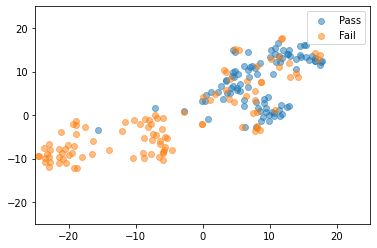

In [2661]:
from sklearn.manifold import TSNE
X_train_embedded = TSNE(n_components=2).fit_transform(np.array(embs))
l1 = np.array(list(set(range(len(g_train))) & set(pass_ix_train)))
l2 = np.array(list(set(range(len(g_train))) & set(fail_ix_train)))
plt.scatter(X_train_embedded[l1,0], X_train_embedded[l1, 1], label='Pass', alpha=0.5)
plt.scatter(X_train_embedded[l2,0], X_train_embedded[l2, 1], label='Fail', alpha=0.5)
plt.legend()
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.show()

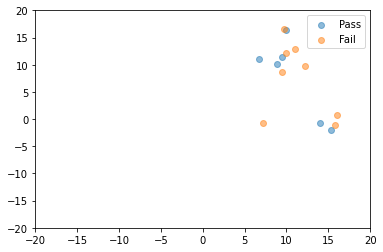

In [2663]:
from sklearn.manifold import TSNE
X_test_embedded = TSNE(n_components=2).fit_transform(np.array(embs))
plt.scatter(X_test_embedded[pass_ix,0], X_test_embedded[pass_ix, 1], label='Pass', alpha=0.5)
plt.scatter(X_test_embedded[fail_ix,0], X_test_embedded[fail_ix, 1], label='Fail', alpha=0.5)
plt.legend()
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.show()

In [2664]:
print('RF Pass:', eval_o1[:, 0])
print('Fail:', eval_o1[:, 1])
print('F1:', eval_o1[:, 3])

RF Pass: [0.71428571 0.28571429 0.71428571 0.57142857 0.71428571 0.85714286
 0.42857143 0.42857143 0.85714286 0.85714286 0.5        1.
 0.5        0.66666667 0.83333333]
Fail: [0.75       0.375      0.875      0.875      0.57142857 0.85714286
 0.85714286 0.57142857 0.57142857 0.71428571 0.875      0.5
 0.75       0.625      0.875     ]
F1: [0.75       0.375      0.82352941 0.77777778 0.61538462 0.85714286
 0.70588235 0.53333333 0.66666667 0.76923077 0.77777778 0.66666667
 0.70588235 0.66666667 0.875     ]


In [2665]:
print('O2 Pass:', eval_o2[:, 0])
print('Fail:', eval_o2[:, 1])
print('F1:', eval_o2[:, 3])

O2 Pass: [0.71428571 0.71428571 0.85714286 0.28571429 0.71428571 0.85714286
 0.71428571 0.42857143 0.85714286 0.85714286 0.16666667 0.83333333
 0.5        0.83333333 0.83333333]
Fail: [0.875      0.75       0.875      1.         0.42857143 0.85714286
 0.71428571 0.42857143 0.57142857 0.85714286 1.         0.75
 0.875      0.75       1.        ]
F1: [0.82352941 0.75       0.875      0.76190476 0.5        0.85714286
 0.71428571 0.42857143 0.66666667 0.85714286 0.76190476 0.8
 0.77777778 0.8        0.94117647]


In [2196]:
from sklearn.metrics import f1_score

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

min_constraints = 0.5 
thresholds = np.arange(0, 1, 0.001)
probs = classifier.predict(X_train).flatten()
scores = [f1_score(y_train, to_labels(probs, t)) for t in thresholds]
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
print('Pass=%.3f, Fail=%.5f' % (balanced_accuracy_score(y_train[pass_ix_train], to_labels(probs[pass_ix_train], thresholds[ix])), balanced_accuracy_score(y_train[fail_ix_train], to_labels(probs[fail_ix_train], thresholds[ix]))))

Threshold=0.590, F-Score=0.98592
Pass=1.000, Fail=0.97222


In [2197]:
print('Total', len(X_test), thresholds[ix], end='\n\n')
probs = classifier.predict(X_test).flatten()
print('Pass', balanced_accuracy_score(y_test[pass_ix], to_labels(probs, thresholds[ix])[pass_ix]))
print('Fail', balanced_accuracy_score(y_test[fail_ix], to_labels(probs, thresholds[ix])[fail_ix]))
print('Over', balanced_accuracy_score(y_test, to_labels(probs, thresholds[ix])))

Total 21 0.59

Pass 0.7692307692307693
Fail 0.5
Over 0.6346153846153846


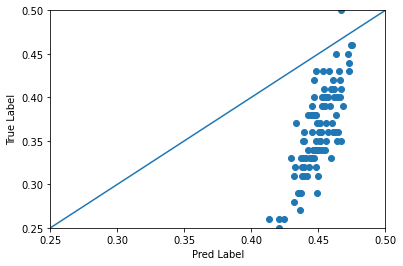

In [1843]:
x1 = []
x2 = []
indexes = np.arange(len(X_train))
for _ in range(100):
    bucket = np.random.choice(indexes, 100)
    x1.append(np.mean(classifier.predict(X_train[bucket]).flatten()))
    x2.append(np.mean(y_train[bucket]))
plt.plot([0,1], [0,1])
plt.scatter(x1, x2)
plt.xlabel('Pred Label')
plt.ylabel('True Label')
plt.xlim([.25, .50])
plt.ylim([.25, .50])
plt.show()

In [1388]:
print('Names', ChenCui().getFeatureNames())
print(X[nuser])

Names ['totalClicks', 'numberSessions', 'totalTimeAllSessions', 'avgSessionTime', 'stdSessionTime', 'totalClicksWeekdays', 'totalClicksWeekends', 'ratioClicksWeekdaysWeekends', 'totalClicksOnProblems', 'totalTimeOnProblems', 'stdTimeOnProblems']
[[3.99000000e+02 1.00000000e+01 4.64770000e+04 4.64770000e+03
  3.69631909e+03 6.00000000e+01 1.12000000e+02 5.35714286e-01
  2.30000000e+02 7.16000000e+02 1.95626553e+01]
 [2.48000000e+02 4.00000000e+00 3.68260000e+04 9.20650000e+03
  6.15895090e+03 1.82000000e+02 5.00000000e+01 3.64000000e+00
  1.24000000e+02 5.83000000e+02 1.98139213e+01]
 [1.47000000e+02 3.00000000e+00 1.35300000e+04 4.51000000e+03
  3.71054075e+03 4.70000000e+01 1.00000000e+02 4.70000000e-01
  6.80000000e+01 6.70000000e+01 3.96715770e+00]
 [2.44000000e+02 3.00000000e+00 1.88130000e+04 6.27100000e+03
  2.45390845e+03 2.18000000e+02 0.00000000e+00 9.81784719e+17
  1.80000000e+02 2.70000000e+02 8.27716984e+00]]


## Model Training and Evaluation

**Points to Consider**

- Basically, the prior work tried all the algorithms included in ScikitLearn. Which algorithms should we use?
    - RandomForest and Lasso for understanding also feature importance. 
    - Check the algorithms which gave the highest accuracy in the prior work. 
    - LSTM (and not Dense) as a deep baseline. 
- How should we combine weekly features for shallow models (for period and for LSTM, there is no problem)? 
    - Average: to get an averaged weekly vector.
    - Vectorization: in this way, we the same feature is duplicated along the feature vector of a student.   
    - None: with random forest, we could ajdust it to receive multivariate time series.
- What should we do with weekly all zero vectors (e.g., no activities in that week)? Should we discard them before training? 

In [378]:
classifier_types = {
    'rf': RandomForestClassifier(),
    'mlp': MLPClassifier(),
    'svm': SVC()
}

In [227]:
classifier_params = {
    'rf': {'n_estimators': [25, 50, 100, 200], 'criterion': ('gini', 'entropy'), 'max_features': ('auto', 'sqrt', 'log2')},
    'mlp': {'activation': ('tanh', 'relu'), 'solver': ('sgd', 'adam'), 'hidden_layer_sizes': [(8,), (16, 8), (32, 16, 8)]},
    'svm': {'C': [1.0, 0.5], 'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'gamma': ('scale', 'auto')} 
}

In [228]:
metrics = {
    'acc': balanced_accuracy_score, 
    'f1': f1_score, 
    'p': precision_score, 
    'r': recall_score, 
    'tp': tp, 'fn': fn, 'tn': tn, 'fp': fp, 
    'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr
}

In [ ]:
classifiers = {} 
scores = {}

for tmode, cmode in product(params['ftime_mode'], params['concat_mode']):
    setup = tmode + '-' + cmode
        
    classifiers[setup] = {}
    scores[setup] = {}
    
    for coindex, (course, data) in enumerate(event_data.items()):
        classifiers[setup][course] = {}
        scores[setup][course] = {}

        # Prediction data
        X = np.arange(len(data['label']['AccountUserID']))
        y = data['label'][params['target']].values

        skf = StratifiedKFold(n_splits=params['n_splits'], shuffle=True, random_state=0)
        for index, (train_index, test_index) in enumerate(skf.split(X, y)):

            # Data split
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fold split
            for findex, flabel in enumerate(feature_sets[tmode][course].keys()):
                classifiers[setup][course][flabel] = {}
                if flabel not in scores[setup][course]:
                    scores[setup][course][flabel] = {}

                # Weekly train
                for windex, wid in enumerate(range(14)):
                    classifiers[setup][course][flabel][wid] = {}
                    if wid not in scores[setup][course][flabel]:
                        scores[setup][course][flabel][wid] = {}

                    # Feature scaling
                    if cmode == 'vec':
                        x_train = feature_sets[tmode][course][flabel][X_train, : (wid + 1)].reshape(len(X_train), -1)
                        x_test = feature_sets[tmode][course][flabel][X_test, : (wid + 1)].reshape(len(X_test), -1)
                    else:
                        x_train = np.mean(feature_sets[tmode][course][flabel][X_train, : (wid + 1), :], axis=1)
                        x_test = np.mean(feature_sets[tmode][course][flabel][X_test, : (wid + 1), :], axis=1)

                    scaler = StandardScaler()
                    scaled_x_train = scaler.fit_transform(x_train)
                    scaled_x_test = scaler.transform(x_test)

                    for cindex, (cname, classifier) in enumerate(classifier_types.items()):
                        # Classifier train with grid search
                        grid = classifier_params[cname]
                        classifiers[setup][course][flabel][wid][cname] = GridSearchCV(classifier, grid, cv=10, scoring='f1')
                        classifiers[setup][course][flabel][wid][cname].fit(scaled_x_train, y_train)

                        if cname not in scores[setup][course][flabel][wid]:
                            scores[setup][course][flabel][wid][cname] = {}

                        # Classifier evaluation
                        for mname, mfunc in metrics.items():
                            clf = classifiers[setup][course][flabel][wid][cname]
                            val = mfunc(y_test, np.around(clf.predict(scaled_x_test)))

                            # Metric calculation
                            if mname not in scores[setup][course][flabel][wid][cname]:
                                scores[setup][course][flabel][wid][cname][mname] = []
                            scores[setup][course][flabel][wid][cname][mname].append(val)

                            # Fold metric averaging
                            if (index + 1) == params['n_splits']:
                                fold_average = np.mean(scores[setup][course][flabel][wid][cname][mname])
                                scores[setup][course][flabel][wid][cname][mname] = fold_average

                        print('\rCourse:', 
                              '{:<20}'.format(course[-20:]), 
                              '- ( Fold:', 
                              '{:02d}'.format(index+1), ')', 
                              '( Setup:', 
                              '{:<10}'.format(setup), ')', 
                              '( Set:', '{:<10}'.format(flabel), 
                              '{:02d}'.format(findex + 1), '{:02d}'.format(len(feature_names)), 
                              ') ( Week:', 
                              '{:02d}'.format(wid + 1), '{:02d}'.format(params['max_course_weeks']), ')', 
                              '- ( Clf:', 
                              '{:<3}'.format(cname), ')', 
                              end='')
                        
        print()

## Experimental Results and Discussion

In [ ]:
lst_data = []
lst_name = []
for setup in scores.keys():
    for course in scores[setup].keys():
        for flabel in scores[setup][course].keys():
            for wid in scores[setup][course][flabel].keys():
                for cname in scores[setup][course][flabel][wid].keys():
                    fixed_values = [setup, course, flabel, wid, cname]
                    fixed_names = ['setup', 'course', 'set', 'week', 'classifier']
                    lst_data.append(fixed_values + list(scores[setup][course][flabel][wid][cname].values())) 
                    lst_name = fixed_names + list(scores[setup][course][flabel][wid][cname].keys())

In [ ]:
df = pd.DataFrame(lst_data, columns=lst_name)

In [ ]:
exp_setup = 'week-avg'

### RQ0 What hyperparameter setting leads to the most accurate results for each algorithm?

In [ ]:
dfp = {}
for cname in classifier_types.keys():
    lst_data = []
    lst_name = []
    for course in scores[exp_setup].keys():
        for flabel in scores[exp_setup][course].keys():
            for wid in scores[exp_setup][course][flabel].keys():
                bestparams_vals = classifiers[exp_setup][course][flabel][wid][cname].best_params_.values()
                bestparams_keys = classifiers[exp_setup][course][flabel][wid][cname].best_params_.keys()
                lst_data.append([course, flabel, wid, cname] + list(bestparams_vals)) 
                lst_name = ['course', 'set', 'week', 'classifier'] + list(bestparams_keys)
    dfp[cname] = pd.DataFrame(lst_data, columns=lst_name)

In [ ]:
def plot_model_parameter_over_weeks(df, classifier, parameter):
    plt.figure(figsize=(30, 6), dpi=360)
    plt.title(parameter  + ' of ' + classifier)
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    
    for cindex, course in enumerate(df[classifier]['course'].unique()):    
        df_features = df[classifier][df[classifier]['course'] == course]
        plt.plot(df_features['week'], df_features[parameter], lw=1, color=colors[cindex], label=course)

        plt.xlim([df_features['week'].values[0], df_features['week'].values[-1]])
        plt.ylim([df_features[parameter].min() - 2, df_features[parameter].max() + 2])
        plt.xlabel('Week')
        plt.ylabel(parameter.title())
        plt.grid(axis='y')
        plt.legend(loc='upper right')
        
    plt.show()

In [ ]:
plot_model_parameter_over_weeks(dfp, 'rf', 'n_estimators')

**Points to Consider**
- Use bar plots instead of line splots, otherwise it is hard to understand overlapping lines. 

### RQ1: What feature set is the best for a given algorithm?

In [ ]:
def plot_metrics_per_model(df, metric, classifier):
    plt.figure(figsize=(30, 6 * (len(df['course'].unique()) // 3 + 1)), dpi=360)
    
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    for cindex, course in enumerate(df['course'].unique()):
        plt.subplot(len(df['course'].unique()) // 3 + 1, 2, cindex + 1)
        
        plt.title(classifier + ' in ' + course)
        for findex, flabel in enumerate(df['set'].unique()): 
            df_features = df[(df['course'] == course) & (df['set'] == flabel)]
            df_classifiers = df_features[df_features['classifier'] == classifier]
            plt.plot(df_classifiers['week'], df_classifiers[metric].values, lw=1, color=colors[findex], label=flabel)

        plt.ylim([0.40, 0.80])
        plt.xlim([df_classifiers['week'].values[0], df_classifiers['week'].values[-1]])
        plt.xlabel('Week')
        plt.ylabel(metric)
        plt.grid(axis='y')
        plt.legend(loc='upper left')
        
    plt.show()

In [ ]:
plot_metrics_per_model(df[df['setup'] == exp_setup], 'acc', 'rf')

### RQ2: What classifier is the best for a given feature set?

In [ ]:
def plot_metrics_per_feature(df, metric, feature_name):

    plt.figure(figsize=(30, 6 * (len(df['course'].unique()) // 3 + 1)), dpi=360)
    
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    for cindex, course in enumerate(df['course'].unique()):
        plt.subplot(len(df['course'].unique()) // 3 + 1, 2, cindex + 1)
        
        df_features = df[(df['course'] == course) & (df['set'] == flabel)]

        plt.title(flabel + ' on ' + course)
        for clfindex, classifier in enumerate(df_features['classifier'].unique()): 
            df_clf = df_features[df_features['classifier'] == classifier]
            plt.plot(df_clf['week'], df_clf[metric].values, lw=1, color=colors[clfindex], label=classifier)

        plt.ylim([0.40, 0.75])
        plt.xlim([df_features['week'].values[0], df_features['week'].values[-1]])
        plt.xlabel('Week')
        plt.ylabel(metric)
        plt.grid(axis='y')
        plt.legend(loc='upper left')

In [ ]:
plot_metrics_per_feature(df[df['setup'] == exp_setup], 'acc', 'chen_cui')

### RQ3: How the feature importance distribution changes over weeks?

In [ ]:
def plot_importance_per_feature(classifiers, classifier, feature_name):

    plt.figure(figsize=(30, 6 * (len(classifiers.keys()) // 3 + 1)), dpi=360)
    
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    for cindex, course in enumerate(classifiers.keys()):
        plt.subplot(len(classifiers.keys()) // 3 + 1, 4, cindex + 1)
        
        rkey = classifiers[course][feature_name][list(classifiers[course][feature_name].keys())[0]]
        
        nweeks = len(classifiers[course][feature_name].keys())
        nfeatures = len(rkey[classifier].best_estimator_.feature_importances_)
        
        plt.title(classifier + ' on ' + course)
        importance_mtx = np.zeros((nweeks, nfeatures))
        for windex, wid in enumerate(classifiers[course][feature_name].keys()):
            importance_mtx[windex] = classifiers[course][feature_name][wid][classifier].best_estimator_.feature_importances_
            
        plt.colorbar(plt.imshow(importance_mtx, cmap='hot', interpolation='nearest', vmin=0, vmax=0.2))
        plt.yticks(range(nweeks), ['Week ' + str(wid) for wid in classifiers[course][feature_name].keys()])
        plt.xticks(range(nfeatures), find_ffunc(feature_name).getFeatureNames(), rotation=90)
        
    plt.show()

In [ ]:
plot_importance_per_feature(classifiers[exp_setup], 'rf', 'chen_cui')

**Points to Consider**
- Somehow sort features on the x-axis based on their importance and highlight the different important heatmap regions across courses. 

### RQ4: Which aggregation of feature over time leads to more accurate models?

In [ ]:
def plot_metrics_per_mode(df, metric, classifier, feature_name):
    plt.figure(figsize=(30, 6 * (len(df['course'].unique()) // 3 + 1)), dpi=360)
    
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    for cindex, course in enumerate(df['course'].unique()):
        plt.subplot(len(df['course'].unique()) // 3 + 1, 2, cindex + 1)
        
        plt.title(classifier  + ' on ' + feature_name + ' in ' + course)
        for sindex, slabel in enumerate(df['setup'].unique()): 
            df_features = df[(df['course'] == course) & (df['set'] == feature_name) & (df['setup'] == slabel)]
            df_classifiers = df_features[df_features['classifier'] == classifier]
            plt.plot(df_classifiers['week'], df_classifiers[metric].values, lw=1, color=colors[sindex], label=slabel)

        plt.ylim([0.40, 0.80])
        plt.xlim([df_classifiers['week'].values[0], df_classifiers['week'].values[-1]])
        plt.xlabel('Week')
        plt.ylabel(metric)
        plt.grid(axis='y')
        plt.legend(loc='upper left')
        
    plt.show()

In [ ]:
plot_metrics_per_mode(df, 'acc', 'rf', 'chen_cui')

**Points to Consider**

- Analyze the probabilities returned by the classifier.
- Build models in such a way that they consider what they predict in the previous week, with a decay parameter. 